In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import pandas as pd
import numpy as np
import ast
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
import pymannkendall as mk
warnings.filterwarnings('ignore')

In [2]:
root = r'C:\Users\samantha.kuzma\OneDrive - World Resources Institute'

# - - - FOLDERS - - -  - - -  - - - #
# ReservoirWatch specific
data_root = os.path.join(root, "ReservoirWatch", "Data")
raw_path = os.path.join(data_root, "Raw")
analysis_path = os.path.join(data_root, "Analysis")
rs_path = os.path.join(analysis_path, "RemotelySensed")
cwc_path = os.path.join(raw_path, "CWC")
# File that matches each reservoir to basins (containing, upstream, downstream)
res_ids_path = os.path.join(analysis_path, "reservoir_to_IDs_lookup.csv")



# Month lookup dictionary
month = {1: "Jan", 2: "Feb", 3: "March", 4: "April", 5: "May", 6: "June",
         7: "July", 8: "Aug", 9: "Sept", 10: "Oct", 11: "Nov", 12: "Dec"}

In [16]:
julian_WL_range_folder = os.path.join(analysis_path, "Plots", "JulianDay_WaterLevels")
ts_WL_range_folder = os.path.join(analysis_path, "Plots", "Daily_WaterLevels")
trends_folder = os.path.join(analysis_path, "Plots", "Trends")
anomalies_path = os.path.join(analysis_path, 'reservoir_anomalies.csv')

season_path = os.path.join(analysis_path, "Plots", "Seasonal", "Precip_vs_WaterLevels")


In [4]:
def fix_dates(df_in, date_name):
    df_in[date_name] = pd.to_datetime(df_in[date_name]) # Set date as date format
    # Add Day, month, year as unique columns
    df_in['Day'] = df_in[date_name].dt.day
    df_in['Month'] = df_in[date_name].dt.month
    df_in['Year'] = df_in[date_name].dt.year
    # Create Ordinal date (sequential day count)
    df_in['OD'] = df_in[date_name].apply(lambda x: x.toordinal())
    # Find ordinal date for the beginning of each year (Jan 1)
    df_inyear = df_in[['Year', 'OD']][(df_in.Month ==1) & (df_in.Day ==1)].set_index(['Year'])
    # Add Create a Julian Date (unique sequential number for that day of the year. 0 - 365)
    df_j = pd.merge(df_in, df_inyear, how = 'left', left_on = 'Year', right_index = True)
    df_j['JD'] = df_j['OD_x'] - df_j['OD_y'] 
    # Clean up date
    df_j.drop(['OD_y'], axis=1, inplace = True)
    df_j.rename(columns = {'OD_x': "OD"}, inplace = True)
    df_j.drop_duplicates(inplace = True)
    # Add text dates
    df_j['text_month'] = df_j['Month'].apply(lambda x: month.get(x))
    df_j['text_date'] = df_j.apply(lambda x: x['text_month'] + " " + str(int(x['Year'])), axis = 1)
    return df_j

In [5]:
# Reserviors
res_list = os.listdir(cwc_path)
print(res_list)

# Remotely Sensed
remote_list = os.listdir(rs_path)
remote_list

['Bargi', 'Hirakud', 'indirasagar', 'Maithon', 'Mettur', 'Panchet', 'Pench', 'Rihand', 'Sriramsagar', 'Tenughat', 'Tilaiya']


['chirps_daily_TS-2000-01-01_2020-12-31_STEP-day_IC-sum_ZS-MEAN_Scale-5000.csv',
 'chirps_daily_TS-2000-01-01_2020-12-31_STEP-day_IC-sum_ZS-SUM_Scale-5000.csv',
 'chirps_daily_TS-2000-01-01_2020-12-31_STEP-month_IC-sum_ZS-MEAN_Scale-5000.csv',
 'chirps_daily_TS-2000-01-01_2020-12-31_STEP-month_IC-sum_ZS-SUM_Scale-5000.csv',
 'modis11a1_daily_TS-2000-01-01_2020-12-31_STEP-day_IC-mean_ZS-MEAN_Scale-5000.csv',
 'modis11a1_daily_TS-2000-01-01_2020-12-31_STEP-month_IC-mean_ZS-MEAN_Scale-5000.csv']

In [6]:
# Read in Reservoir ID list, turn PFAF ID lists from strings to list
df_resids = pd.read_csv(res_ids_path, header = 0, index_col = 0)
df_resids['PFAF_ID'] = df_resids['PFAF_ID'].apply(lambda x: ast.literal_eval(x))
df_resids['PFAF_UP'] = df_resids['PFAF_UP'].apply(lambda x: ast.literal_eval(x))
df_resids['PFAF_DN'] = df_resids['PFAF_DN'].apply(lambda x: ast.literal_eval(x))

Bargi
              avg_00_10    avg_11_20
Year        2005.500000  2015.500000
Precip        22.091007    22.544329
monthly_wl   414.766009   418.681936
Hirakud
              avg_00_10    avg_11_20
Year        2005.500000  2015.500000
Precip        55.356604    59.192762
monthly_wl   188.814355   190.252337
indirasagar
              avg_00_10    avg_11_20
Year        2005.500000  2015.500000
Precip        15.052261    17.263030
monthly_wl   247.925529   255.914982
Maithon
              avg_00_10    avg_11_20
Year        2005.500000  2015.500000
Precip        16.386949    13.506981
monthly_wl   145.560186   144.349659
Mettur
              avg_00_10    avg_11_20
Year        2005.500000  2015.500000
Precip         6.295832     6.435640
monthly_wl   226.360056   225.717957
Panchet
              avg_00_10    avg_11_20
Year        2005.500000  2015.500000
Precip        17.326693    15.986090
monthly_wl   124.630831   123.998881
Pench
              avg_00_10    avg_11_20
Year        2005.500

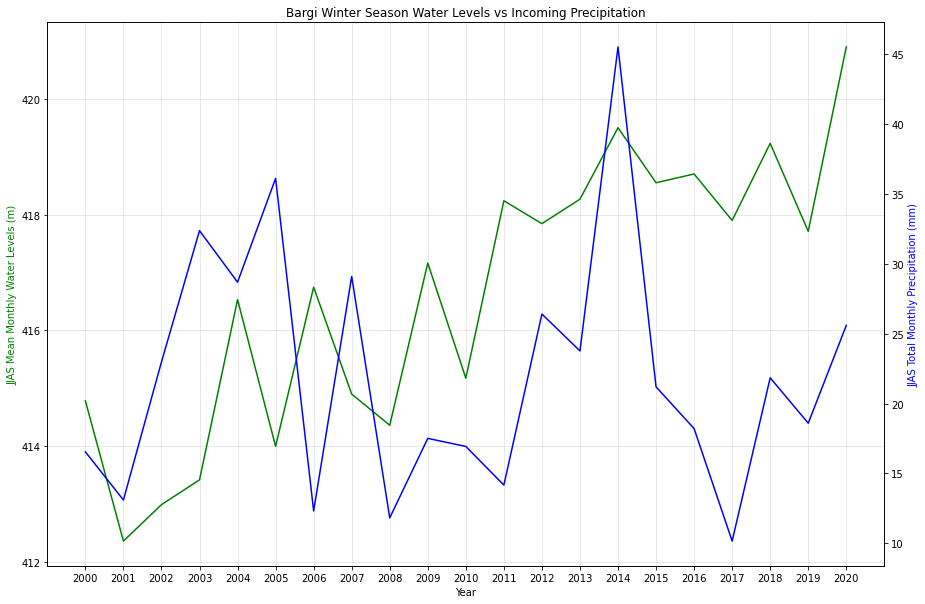

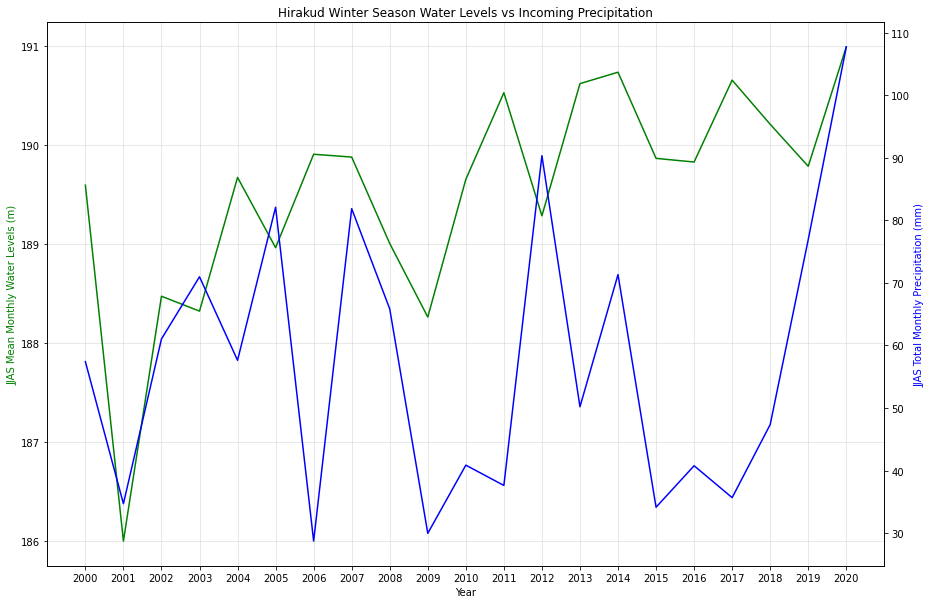

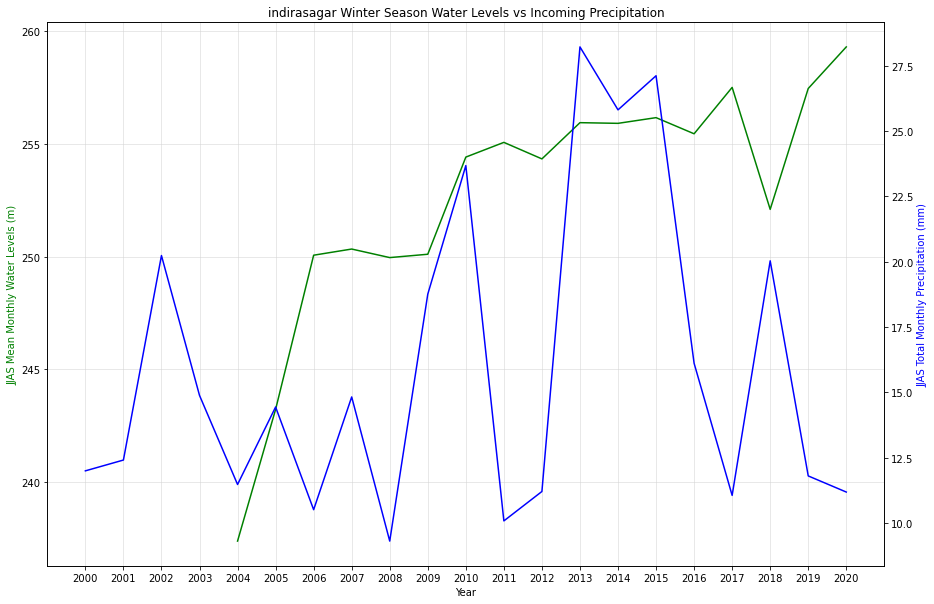

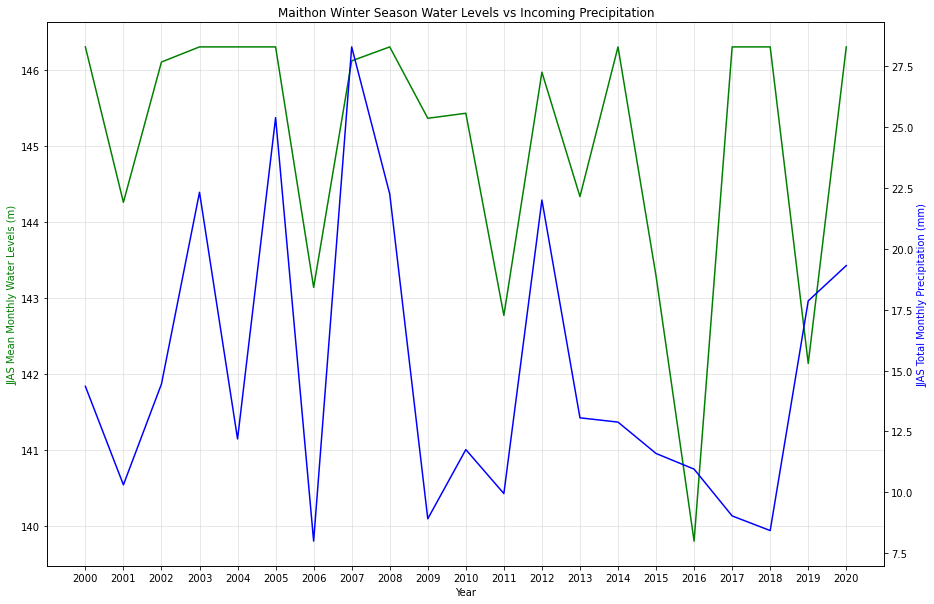

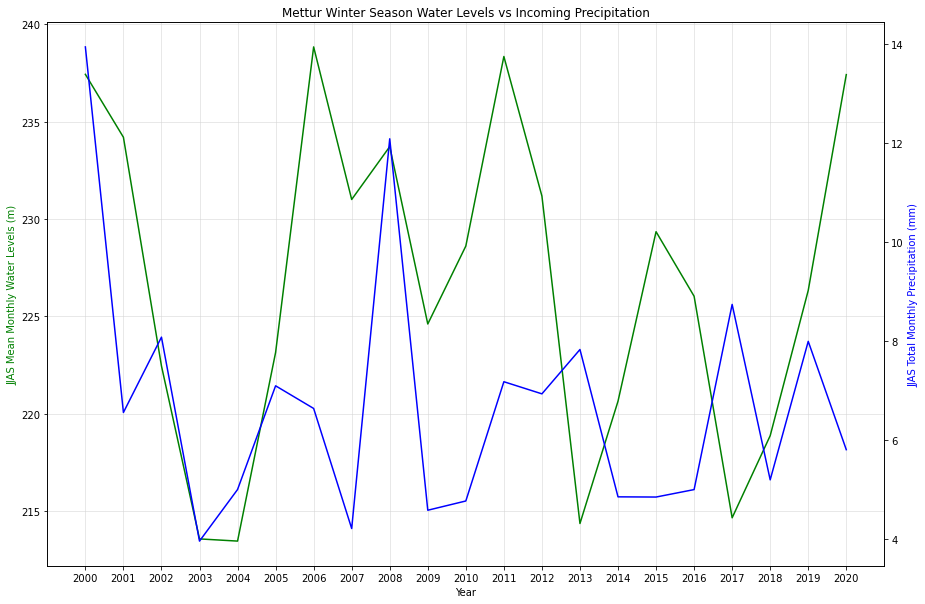

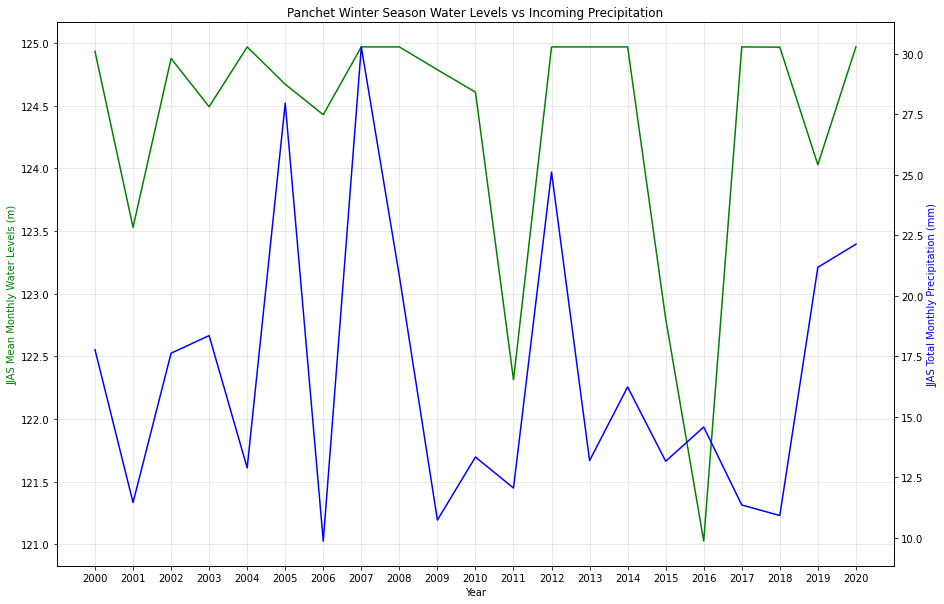

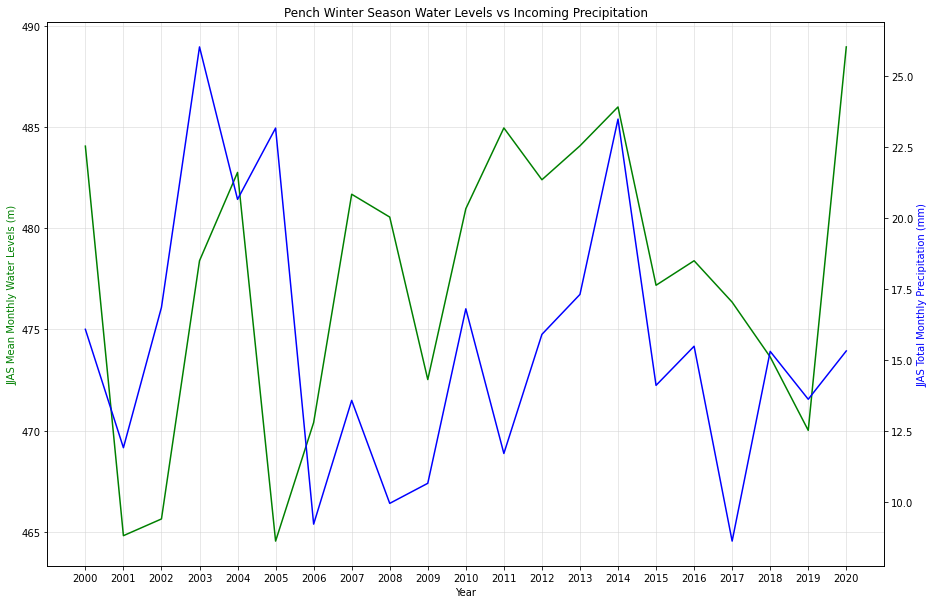

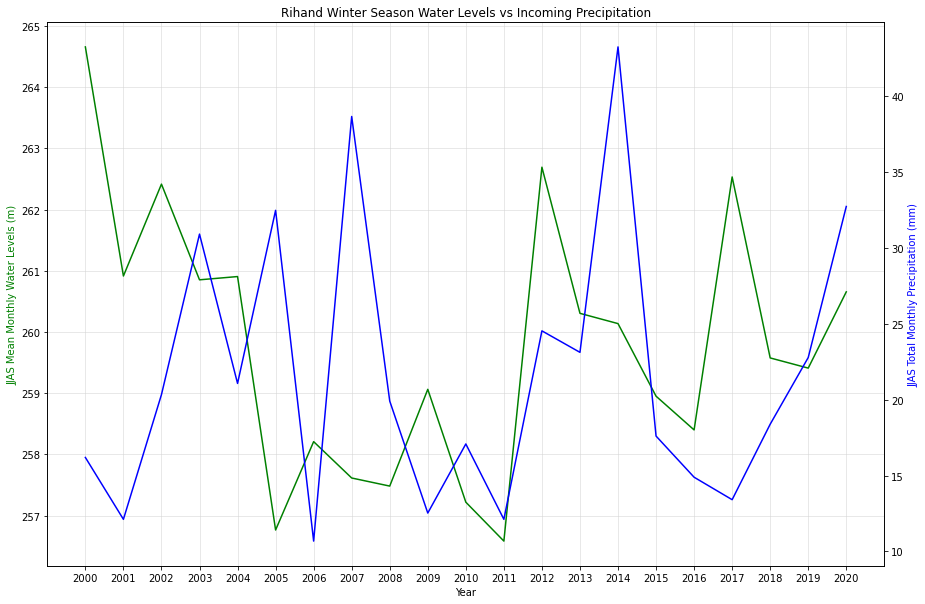

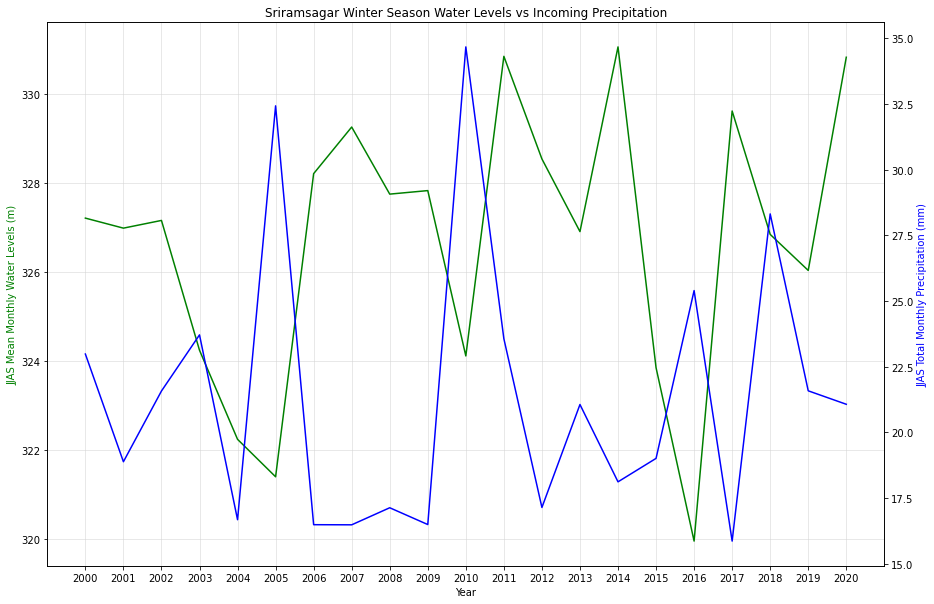

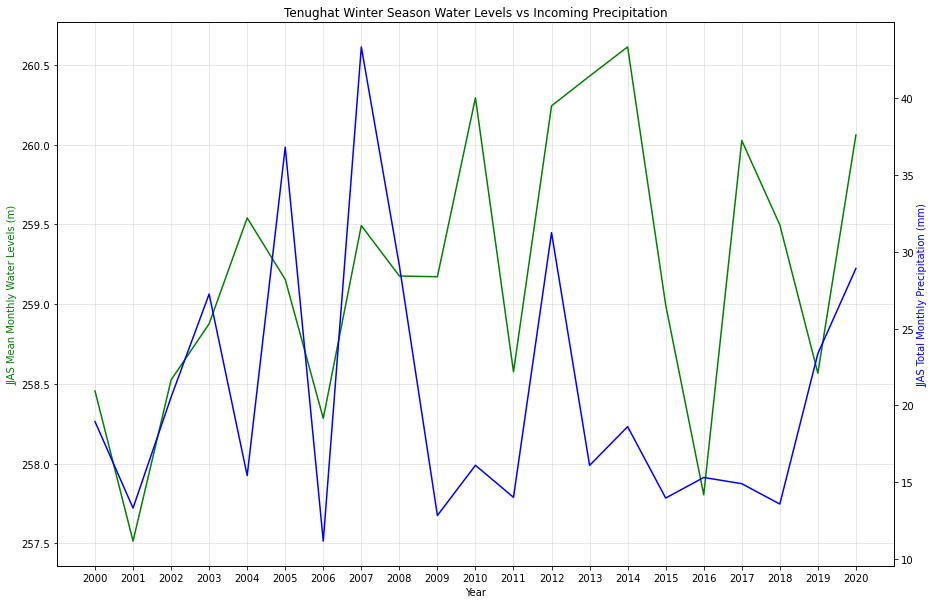

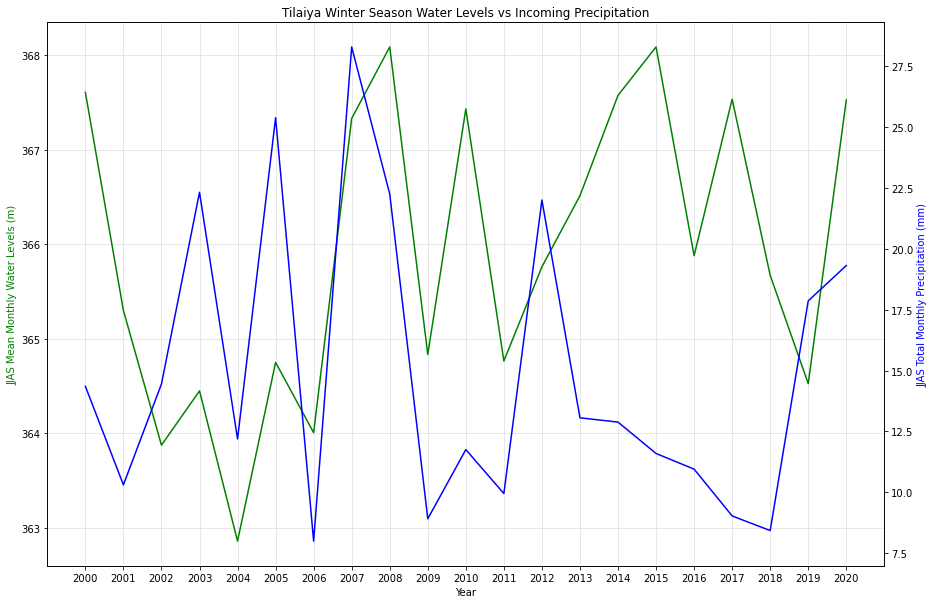

In [31]:
# Create dataframe to hold Mann-Kendall results
df_mk_wl = pd.DataFrame(index = res_list, columns = ['trend', 'h', 'p'])
df_mk_pr = pd.DataFrame(index = res_list, columns = ['trend', 'h', 'p'])
# PRECIP TYPE
stat_type = 'mean'
# Set parameter name and file name
field = 'monthly_{:s}_precip'.format(stat_type)
remote_file = 'chirps_daily_TS-2000-01-01_2020-12-31_STEP-month_IC-sum_ZS-{:s}_Scale-5000.csv'.format(stat_type.upper())
# Read in data, fix dates, rename columns
df_p = pd.read_csv(os.path.join(rs_path, remote_file), index_col = 0)
df_p = fix_dates(df_p, 'date')
df_p.rename(columns = {stat_type: field}, inplace = True)

for res in res_list:
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - READ IN RESERVOIR DATA - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    print(res)
    season = "Winter"
    season_months = [1, 2]
    res_img = os.path.join(season_path, "{:s}_{:s}.png".format(res, season)) # Path to save image results
    # Daily reservoir levels
    res_cwc = os.path.join(cwc_path, res, '{:s}_00_21.csv'.format(res)) # Reservoir CWC data file
    df_r = pd.read_csv(res_cwc, header = 1) # Read in reservoir CWC data
    df_r = fix_dates(df_r, 'Dates')
    df_r.rename(columns = {"Current Year Level (m)": "waterlevel_m"}, inplace = True)
    df_r['level_pct'] = (df_r['waterlevel_m'] / df_r['Full Reservoir Level']) * 100 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - CONNECTING WATERSHEDS - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    main_pf = df_resids.loc[res, 'PFAF_ID']
    up_pf = df_resids.loc[res, 'PFAF_UP']
    down_pf = df_resids.loc[res, 'PFAF_DN']
    all_pf = main_pf + up_pf + down_pf
    all_pf = sorted(list(set(all_pf)))
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - JJAS PRECIP IN CONNECTING WATERSHEDS - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    df_p_jjas = df_p[df_p.Month.isin(season_months)]
    df_piv = pd.pivot_table(df_p_jjas, values=field, index="Year", columns="PFAF_ID", aggfunc='mean', fill_value=0)
    # All watersheds for that basin
    df_piv_f = df_piv.filter(all_pf)
    # All watersheds for that basin
    df_piv_in = df_piv.filter(main_pf + up_pf).sum(axis=1).to_frame(name = 'Precip')
    # Summed by upstream, downstream, at
    df_piv_up = df_piv.filter(up_pf).sum(axis=1).to_frame(name = 'Upstream')
    df_piv_dn = df_piv.filter(down_pf).sum(axis=1).to_frame(name = 'Downstream')
    df_piv_at = df_piv.filter(main_pf).sum(axis=1).to_frame(name = 'Precip')
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - JJAS WATER LEVELS IN SELECT RESERVOIR - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # Create Monsoon season mean water level per year
    df_r_f = df_r[df_r.Month.isin(season_months)]
    df_r_m = df_r_f.groupby(['Year'])['waterlevel_m'].mean().to_frame(name='monthly_wl').reset_index()
    df_r_m.sort_values(['Year'], inplace = True)
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # - - - - - - - - - - PLOT - - - - - - - - - - 
    #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    df_p2 = df_piv_at.reset_index() # Make a copy where 
    df_merge = pd.merge(df_p2, df_r_m, how = 'left', left_on = 'Year', right_on = 'Year')
    avg01_10 = df_merge.iloc[1:11].mean().to_frame(name = 'avg_00_10')
    avg11_20 = df_merge.iloc[11:].mean().to_frame(name = 'avg_11_20')
    df_avg_merge = pd.merge(avg01_10, avg11_20, how = 'left', left_index = True, right_index = True)
    print(df_avg_merge)
    # Create X values using year
    x = df_merge.Year.tolist() # Julian day values
    my_xticks = [str(int(y)) for y in x]
    # Create Y values from reservoir and precip data
    y1 = df_merge['monthly_wl'].tolist()
    y2 = df_merge['Precip'].tolist()
    # Perform Mann-Kendall trend analysis
    mk_wl = mk.original_test(y1)
    mk_pr = mk.original_test(y2)
    df_mk_wl.loc[res] = mk_wl[0:3]
    df_mk_pr.loc[res] = mk_pr[0:3]

    # # Create plot
    fig, ax1 = plt.subplots(figsize=(15,10))
    ax2 = ax1.twinx()
    ax1.plot(x, y1, 'g-')
    ax2.plot(x, y2, 'b-')
    plt.xticks(x, my_xticks, rotation=45) # Create plot labels
    ax1.set_xlabel('Year')
    ax1.set_ylabel('JJAS Mean Monthly Water Levels (m)', color='g')
    ax2.set_ylabel('JJAS Total Monthly Precipitation (mm)', color='b')
    ax1.title.set_text('{:s} {:s} Season Water Levels vs Incoming Precipitation'.format(res, season))
    ax1.grid(color='lightgray', linestyle='-', linewidth=0.5)
    # Download figure and close it
    fig.savefig(res_img, bbox_inches='tight')
#     fig.close()

In [28]:
df_mk_pr

,trend,h,p
Bargi,no trend,False,0.566143
Hirakud,no trend,False,0.450295
indirasagar,no trend,False,0.349219
Maithon,no trend,False,0.785797
Mettur,no trend,False,0.17419
Panchet,no trend,False,0.879988
Pench,no trend,False,0.607708
Rihand,no trend,False,0.694644
Sriramsagar,no trend,False,0.263872
Tenughat,no trend,False,0.566143


Mettur
              avg_00_10    avg_11_20
Year        2005.500000  2015.500000
Precip       607.958257   447.660003
monthly_wl   231.022380   230.595302
Mann_Kendall_Test(trend='no trend', h=False, p=0.566142727568169, z=0.5737415195948353, Tau=0.09523809523809523, s=20.0, var_s=1096.6666666666667, slope=0.08441119104929738, intercept=231.63099678515917)
Mann_Kendall_Test(trend='decreasing', h=True, p=0.03203437170592571, z=-2.1439814679596476, Tau=-0.34285714285714286, s=-72.0, var_s=1096.6666666666667, slope=-7.698812897098724, intercept=611.0925768492084)


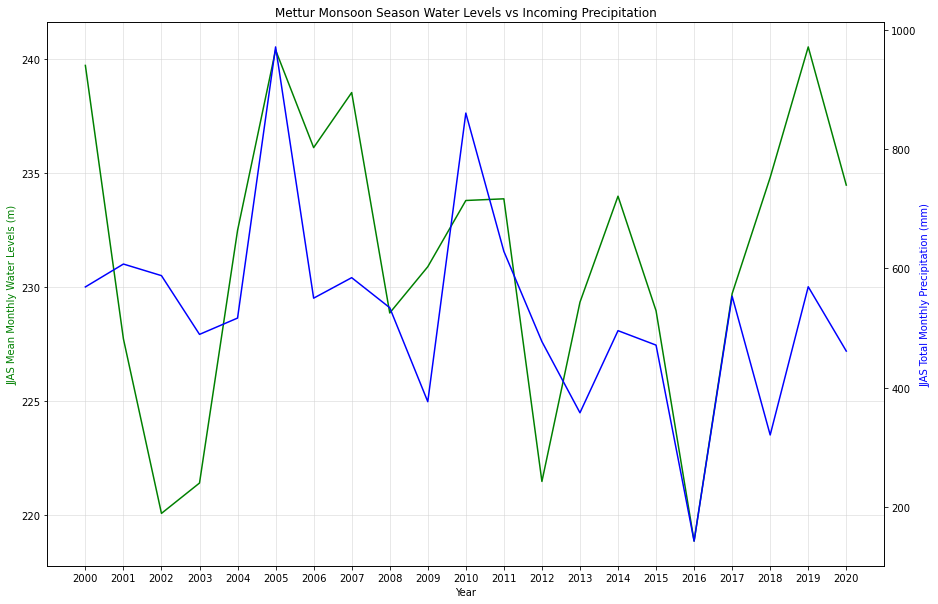

In [37]:
seasons_dict = {'Winter': [1,2], "Summer": [3, 4, 5], 
                'Monsoon': [6, 7, 8, 9], "PostMonsoon": [10, 11, 12]}

res = 'Mettur'
season = "PostMonsoon"
season_months = seasons_dict.get(season)
# PRECIP TYPE
stat_type = 'mean'
# Set parameter name and file name
field = 'monthly_{:s}_precip'.format(stat_type)
remote_file = 'chirps_daily_TS-2000-01-01_2020-12-31_STEP-month_IC-sum_ZS-{:s}_Scale-5000.csv'.format(stat_type.upper())
# Read in data, fix dates, rename columns
df_p = pd.read_csv(os.path.join(rs_path, remote_file), index_col = 0)
df_p = fix_dates(df_p, 'date')
df_p.rename(columns = {stat_type: field}, inplace = True)


#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - READ IN RESERVOIR DATA - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
print(res)
# Daily reservoir levels
res_cwc = os.path.join(cwc_path, res, '{:s}_00_21.csv'.format(res)) # Reservoir CWC data file
df_r = pd.read_csv(res_cwc, header = 1) # Read in reservoir CWC data
df_r = fix_dates(df_r, 'Dates')
df_r.rename(columns = {"Current Year Level (m)": "waterlevel_m"}, inplace = True)
df_r['level_pct'] = (df_r['waterlevel_m'] / df_r['Full Reservoir Level']) * 100 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - CONNECTING WATERSHEDS - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
main_pf = df_resids.loc[res, 'PFAF_ID']
up_pf = df_resids.loc[res, 'PFAF_UP']
down_pf = df_resids.loc[res, 'PFAF_DN']
all_pf = main_pf + up_pf + down_pf
all_pf = sorted(list(set(all_pf)))
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - JJAS PRECIP IN CONNECTING WATERSHEDS - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
df_p_jjas = df_p[df_p.Month.isin(season_months)]
df_piv = pd.pivot_table(df_p_jjas, values=field, index="Year", columns="PFAF_ID", aggfunc='mean', fill_value=0)
# All watersheds for that basin
df_piv_f = df_piv.filter(all_pf)
# All watersheds for that basin
df_piv_in = df_piv.filter(main_pf + up_pf).sum(axis=1).to_frame(name = 'Precip')
# Summed by upstream, downstream, at
df_piv_up = df_piv.filter(up_pf).sum(axis=1).to_frame(name = 'Upstream')
df_piv_dn = df_piv.filter(down_pf).sum(axis=1).to_frame(name = 'Downstream')
df_piv_at = df_piv.filter(main_pf).sum(axis=1).to_frame(name = 'Precip')
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - JJAS WATER LEVELS IN SELECT RESERVOIR - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# Create Monsoon season mean water level per year
df_r_f = df_r[df_r.Month.isin(season_months)]
df_r_m = df_r_f.groupby(['Year'])['waterlevel_m'].mean().to_frame(name='monthly_wl').reset_index()
df_r_m.sort_values(['Year'], inplace = True)
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - PLOT - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
df_p2 = df_piv_in.reset_index() # Make a copy where 
df_merge = pd.merge(df_p2, df_r_m, how = 'left', left_on = 'Year', right_on = 'Year')
# Compare average precip and water levels
avg01_10 = df_merge.iloc[1:11].mean().to_frame(name = 'avg_00_10')
avg11_20 = df_merge.iloc[11:].mean().to_frame(name = 'avg_11_20')
df_avg_merge = pd.merge(avg01_10, avg11_20, how = 'left', left_index = True, right_index = True)
print(df_avg_merge)
# Create X values using year
x = df_merge.Year.tolist() # Julian day values
my_xticks = [str(int(y)) for y in x]
# Create Y values from reservoir and precip data
y1 = df_merge['monthly_wl'].tolist()
y2 = df_merge['Precip'].tolist()
print(mk.original_test(y1))
print(mk.original_test(y2))
# # Create plot
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')
plt.xticks(x, my_xticks, rotation=45) # Create plot labels
ax1.set_xlabel('Year')
ax1.set_ylabel('JJAS Mean Monthly Water Levels (m)', color='g')
ax2.set_ylabel('JJAS Total Monthly Precipitation (mm)', color='b')
ax1.title.set_text('{:s} Monsoon Season Water Levels vs Incoming Precipitation'.format(res))
ax1.grid(color='lightgray', linestyle='-', linewidth=0.5)
plt.show()

In [39]:
mk.original_test(df_piv_in['Precip'])

Mann_Kendall_Test(trend='decreasing', h=True, p=0.03203437170592571, z=-2.1439814679596476, Tau=-0.34285714285714286, s=-72.0, var_s=1096.6666666666667, slope=-7.698812897098724, intercept=611.0925768492084)

              avg_00_10    avg_11_20
Year        2005.500000  2015.500000
Precip       264.518083   274.693898
monthly_wl   365.793443   366.380886


In [340]:
df_merge.iloc[10:]

,Year,Precip,monthly_wl
10,2010,200.442452,364.308033
11,2011,264.283057,366.149180
12,2012,253.858518,366.746803
13,2013,228.908998,365.530738
14,2014,263.984629,367.814917
15,2015,265.810592,367.321368
16,2016,328.785336,366.372333
17,2017,311.313166,367.291803
18,2018,233.062581,365.488434
19,2019,258.886778,364.156529


### Precipitation at all watersheds

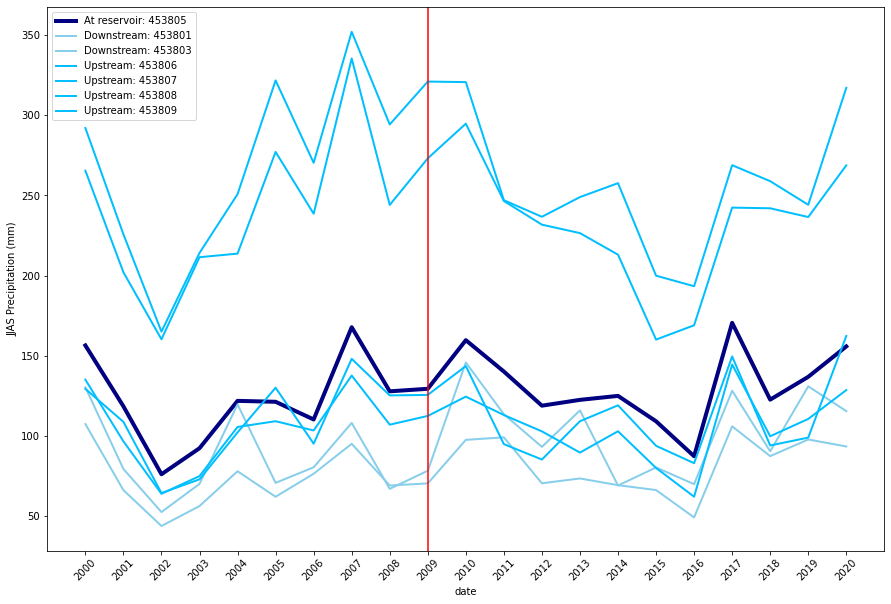

In [181]:
fig,ax = plt.subplots(figsize=(15,10))

lbl = "{:s}: {:s}".format

x = df_piv_at.index.tolist() # Julian day values
my_xticks = [str(int(y)) for y in x]
plt.xticks(x, my_xticks, rotation=45) # Create plot labels

for pf in main_pf:
    ax.plot(df_piv_f.index, df_piv_f[pf], color='red', linewidth=4, label=lbl("At reservoir", str(pf)))

for pf in down_pf:
    ax.plot(df_piv_f.index, df_piv_f[pf], color='skyblue', linewidth=2, label=lbl("Downstream", str(pf)))
    
for pf in up_pf:
    ax.plot(df_piv_f.index, df_piv_f[pf], color='deepskyblue', linewidth=2, label= lbl("Upstream", str(pf)))
    
plt.axvline(x=2009, color = 'red')    
ax.set_xlabel("date")
ax.set_ylabel("JJAS Precipitation (mm)")
ax.legend(loc='best')

## Precipitation summed by upstream, downstream, at reservoir

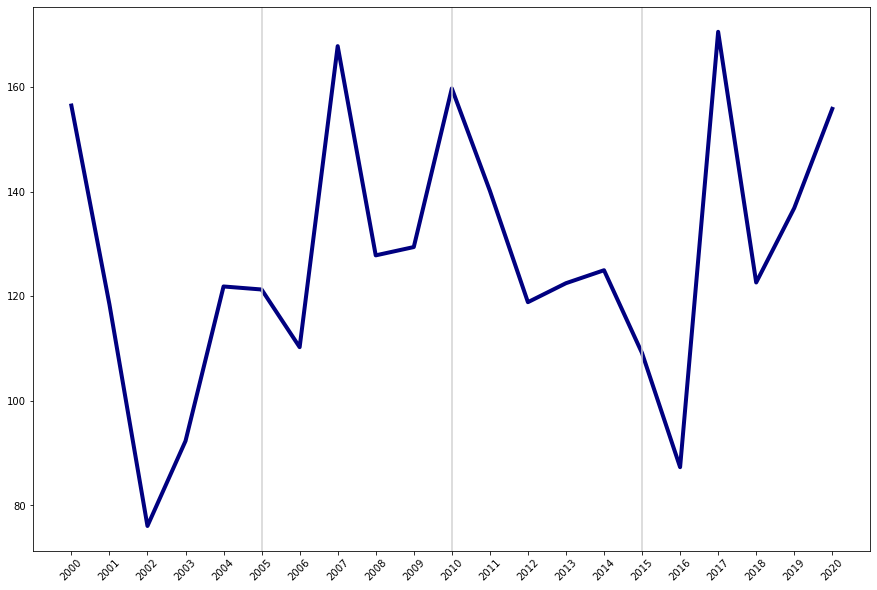

In [199]:
lbl = "{:s}: {:s}".format
plt.figure(figsize=(15,10)) 
# Create X values using Julian Day
x = df_piv_at.index.tolist() # Julian day values
my_xticks = [str(int(y)) for y in x]
plt.xticks(x, my_xticks, rotation=45) # Create plot labels
# Create plot
plt.plot( x,'At reservoir', data=df_piv_at, color='navy', linewidth=4, label = "At reservoir")
# plt.plot( x,'Upstream', data=df_piv_up, color='deepskyblue', linewidth=2, label = "Upstream")
# plt.plot( x,'Downstream', data=df_piv_dn, color='skyblue', linewidth=2, label = "Downstream")
# plt.axvline(x=2005, color = 'red')
# plt.axvline(x=2009, color = 'red')
# plt.axvline(x=2013, color = 'red')
plt.axvline(x=2005, color = 'lightgray')
plt.axvline(x=2010, color = 'lightgray')
plt.axvline(x=2015, color = 'lightgray')
ax.set_xlabel("date")
ax.set_ylabel("JJAS Precipitation (mm)")
ax.legend(loc='best')

## Precipitation summed by upstream, downstream, at reservoir

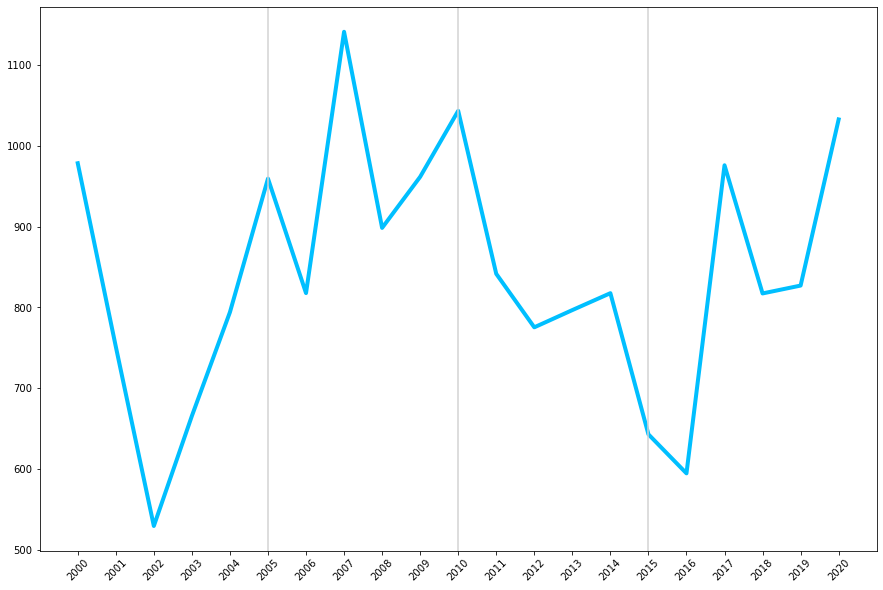

In [201]:
lbl = "{:s}: {:s}".format
plt.figure(figsize=(15,10)) 
# Create X values using Julian Day
x = df_piv_at.index.tolist() # Julian day values
my_xticks = [str(int(y)) for y in x]
plt.xticks(x, my_xticks, rotation=45) # Create plot labels
# Create plot
plt.plot( x,'Precip in', data=df_piv_in, color='deepskyblue', linewidth=4, label = "At reservoir")
plt.axvline(x=2005, color = 'lightgray')
plt.axvline(x=2010, color = 'lightgray')
plt.axvline(x=2015, color = 'lightgray')
ax.set_xlabel("date")
ax.set_ylabel("JJAS Precipitation (mm)")
ax.legend(loc='best')

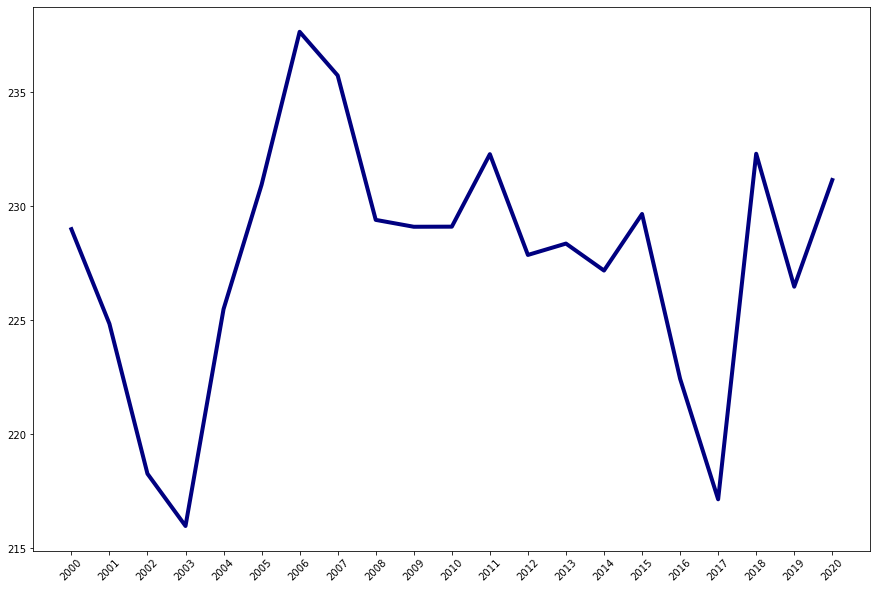

In [280]:
plt.figure(figsize=(15,10)) 
# Create X values using Julian Day
x = df_r_m.Year.tolist() # Julian day values
my_xticks = [str(int(y)) for y in x]
plt.xticks(x, my_xticks, rotation=45) # Create plot labels
# # Create plot
plt.plot( x,'monthly_wl', data=df_r_m, color='navy', linewidth=4)


In [258]:
df_r_m = df_r.groupby(['Month', 'Year', 'text_date'])['waterlevel_m'].sum().to_frame(name='monthly_wl').reset_index()
df_r_m['text_clean'] = df_r_m['text_date']
df_r_m['text_clean'][~df_r_m['text_date'].str.contains('Jan')] = ""
df_r_m.sort_values(['Year', 'Month'], inplace = True)
df_r_m['new_OD'] = range(0, len(df_r_m))
df_r_m = df_r_m[df_r_m.text_clean != 'Jan 2021']

,Precip in
Year,
2000,978.388322
2001,751.611131
2002,529.549349
2003,665.713141
2004,794.070989
2005,959.389976
2006,817.704859
2007,1141.009000
2008,898.391392


In [261]:
df_r_m = df_r.groupby(['Month', 'Year', 'text_date'])['waterlevel_m'].mean().to_frame(name='monthly_wl').reset_index()
df_r_m['text_clean'] = df_r_m['text_date']
df_r_m['text_clean'][~df_r_m['text_date'].str.contains('Jan')] = ""
df_r_m.sort_values(['Year', 'Month'], inplace = True)
df_r_m['new_OD'] = range(0, len(df_r_m))
df_r_m = df_r_m[df_r_m.text_clean != 'Jan 2021']

In [264]:
df_r_m.to_csv('mutter_wl.csv')

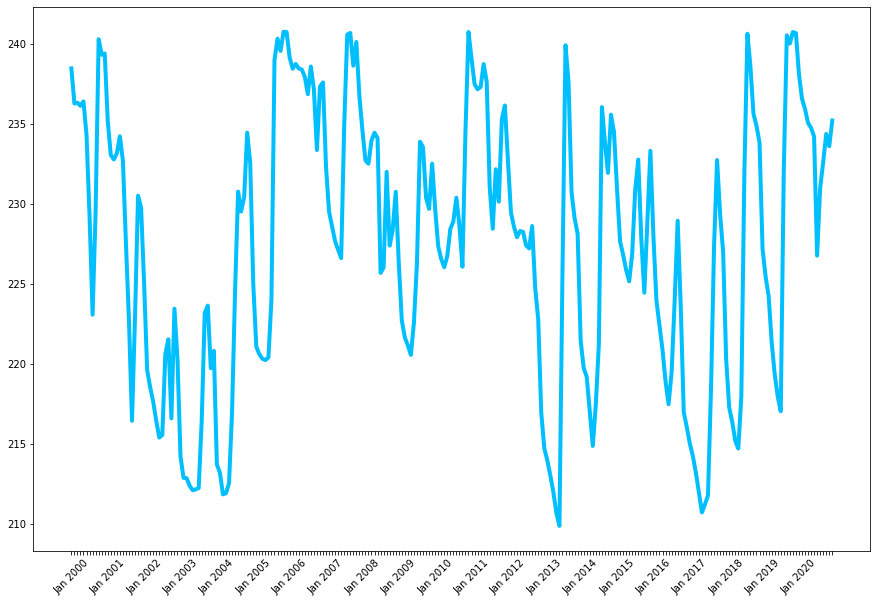

In [262]:
plt.figure(figsize=(15,10)) 
# Create X values using Julian Day
x = df_r_m.new_OD.tolist() # Julian day values
my_xticks = df_r_m['text_clean'].tolist()
plt.xticks(x, my_xticks, rotation=45) # Create plot labels
# # Create plot
plt.plot( x,'monthly_wl', data=df_r_m, color='deepskyblue', linewidth=4)
# plt.axvline(x=2005, color = 'lightgray')
# plt.axvline(x=2010, color = 'lightgray')
# plt.axvline(x=2015, color = 'lightgray')
# ax.set_xlabel("date")
# ax.set_ylabel("JJAS Precipitation (mm)")
# ax.legend(loc='best')